# Example usage of py-wsi

Author: @ysbecca

More information on py-wsi usage is available on my blog: [Rebecca Stone Blog](ysbecca.github.io)

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import py_wsi
import py_wsi.imagepy_toolkit as tk

In [4]:
FILE = '136203.svs'

Set parameters for file directory of SVS images, patch size, level (magnification), and overlap.

In [5]:
file_dir = "/media/disk1/mingrui-projects/py-wsi/"
xml_dir = file_dir
patch_size = 1024
level = 10
db_location = ""
db_name = "patch_db"
overlap = 0

# All possible labels mapped to integer ids in order of increasing severity.
label_map = {'Normal': 0,
             'Benign': 1,
             'Carcinoma in situ': 2,
             'In situ carcinoma': 2,
             'Carcinoma invasive': 3,
             'Invasive carcinoma': 3,
            }

Create a new py-wsi manager object for our collection of svs images. It's called a turtle.

In [6]:
turtle = py_wsi.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map)

2 WSI found in directory.


The Turtle object keeps track of how many WSI images are in its collection, and the LMDB that stores the patches and their info.

In [7]:
print("Total WSI images:    " + str(turtle.num_files))
print("LMDB name:           " + str(turtle.db_name))
print("File names:          " + str(turtle.files))
print("XML files found:     " + str(turtle.get_xml_files()))

Total WSI images:    2
LMDB name:           patch_db
File names:          ['136199.svs' '136203.svs']
XML files found:     []


The Turtle manager allows you to explore the dimensions and tile levels of your images.

```python
def retrieve_tile_dimensions(file_name, patch_size=0, overlap=0, tile_size=0):
    # Locates the file and retrieves tile information.
    return level_count, level_tiles, level_dims
```


In [8]:
level_count, level_tiles, level_dims = turtle.retrieve_tile_dimensions(FILE, patch_size=128)
print("Level count:         " + str(level_count))
print("Level tiles:         " + str(level_tiles))
print("Level dimensions:    " + str(level_dims))

Setting patch size 128 and tile size 128
Level count:         18
Level tiles:         ((1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (3, 3), (5, 5), (9, 9), (18, 18), (36, 35), (72, 69), (144, 138), (288, 276), (576, 552))
Level dimensions:    ((1, 1), (2, 2), (3, 3), (5, 5), (9, 9), (18, 18), (36, 35), (72, 69), (144, 138), (288, 276), (576, 552), (1152, 1104), (2304, 2207), (4607, 4413), (9213, 8826), (18426, 17652), (36852, 35304), (73703, 70608))


The Turtle manager can also return a sample patch.

```python
def retrieve_sample_patch(file_name, patch_size, level, overlap=0):
    # Fetches a sample patch from the centre of the image.
    return patch
```

In [9]:
patch_1 = turtle.retrieve_sample_patch(FILE, 256, 12, overlap=12)
patch_2 = turtle.retrieve_sample_patch(FILE, 128, 12, overlap=12)
patch_3 = turtle.retrieve_sample_patch(FILE, 64, 12, overlap=12)

The imagepy_toolkit included in py_wsi allows for quick displaying of patches.

```python
def show_images(array_of_patches, patches_per_row, patches_per_col)
```

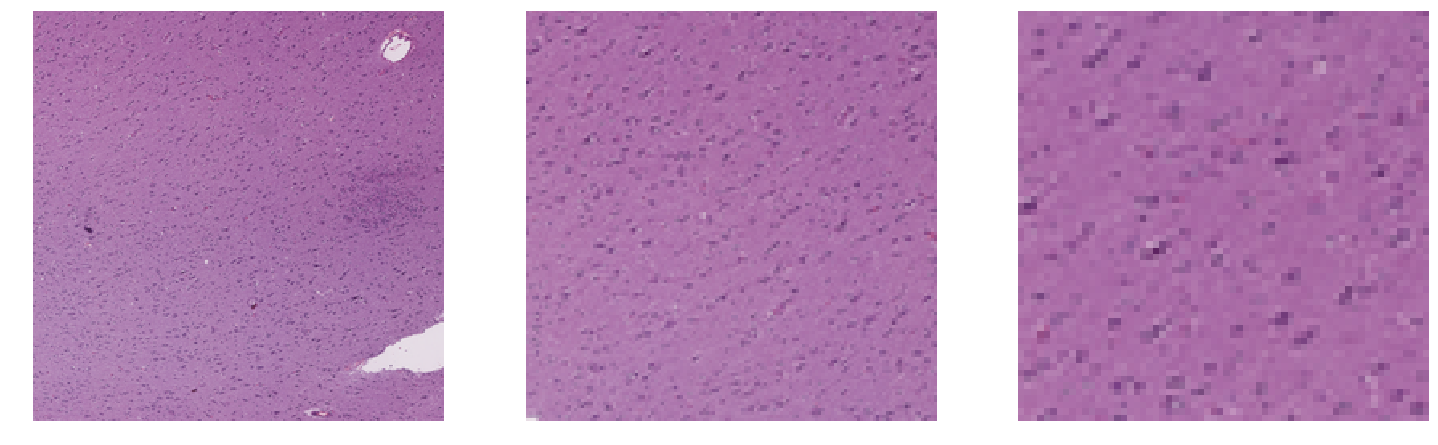

In [10]:
tk.show_images([patch_1, patch_2, patch_3], 3, 1)

Once you have decided what patch size and level you need, you can sample patches and store them in a new LMDB database. This actually creates two databases, one for the patches themselves and another for the image metadata, specifically, the tile dimensions. The second database is only used internally, for retrieving patches from the first database.

**load_xml=True** looks for XML files in the XML directory and labels patches according to any regions provided 
in the XML files. If there are any region names found in the XML files which do not match keys in the label_map, an error message will show and the patches will be given the default label of -1.

In [ ]:
print("Patch size:", patch_size)
turtle.sample_and_store_patches(patch_size, 17, overlap, load_xml=False, limit_bounds=True)

Patch size: 1024
0  calculate_map_size: 136199.svs
1  calculate_map_size: 136203.svs
Pre-calculated map sizes:
 - patch db:     905290186752 bytes
 - meta db:      2631168 bytes
Creating new LMDB environment...
136199.svs 90 59


## Loading patches from LMDBs

Now you can load the patches and associated meta data from the database using the Turtle manager. The Turtle supports several ways of retrieving patches.

**(1) From one specific image at a time:**

In [40]:
patches, coords, classes, labels = turtle.get_patches_from_file(FILE)

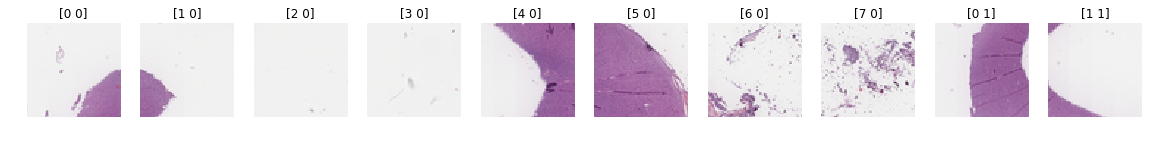

In [41]:
tk.show_labeled_patches(patches[:10], coords[:10])

**(2) By sets (assuming training with batches as is often the case with large datasets). The sets are computed very simply where the ith image in the directory belongs to the ith set. **

In [55]:
set_id = 1
total_sets = 2
patches, coords, classes, labels = turtle.get_set_patches(set_id, total_sets)

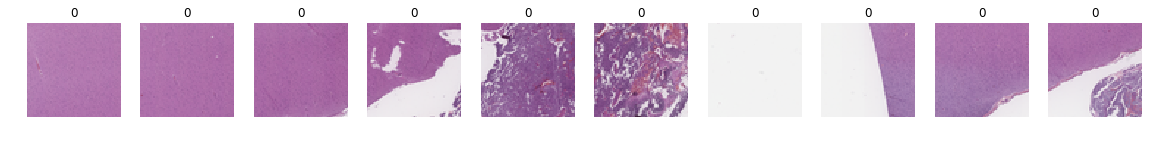

In [56]:
tk.show_labeled_patches(patches[50:60], classes[50:60])

**(3) Alternatively, you can specify your own set by passing a binary selection array, where from all non-zero indices i will result in all patches from the ith image in the directory being loaded.**

```python
def get_set_patches(self, set_id, total_sets, select=[]):
    # The default: ith image in directory belonging to the ith set
    select = np.zeros(self.num_files)
    select[set_id:self.num_files:total_sets] = 1
```

An example of passing in a custom select array:

In [44]:
custom_set_select = [0, 1]
total_sets = 2
set_id = 1

patches, coords, classes, labels = turtle.get_set_patches(set_id, total_sets, select=custom_set_select)

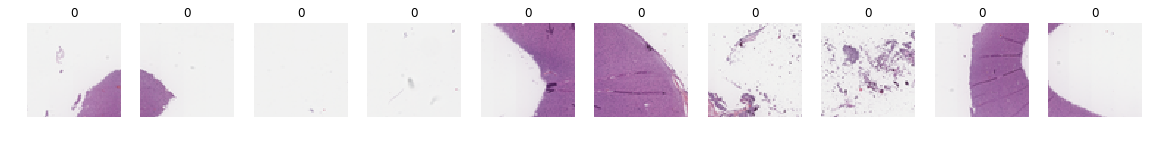

In [45]:
tk.show_labeled_patches(patches[:10], classes[:10])

## The py-wsi Dataset object

A simple Dataset object is also included, adapted from the [Hvass-Labs tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials).

In [46]:
import py_wsi.dataset as ds

In [47]:
dataset = ds.read_datasets(turtle,
                set_id=1,
                valid_id=0,
                total_sets=2,
                shuffle_all=True,
                augment=True)

We can see the dataset information read in from the LMDB:

In [48]:
print("Total training set patches:     " + str(len(dataset.train.images)))
print("Total validation set patches:   " + str(len(dataset.valid.images)))

Total training set patches:     576
Total validation set patches:   693


And can view some of the original patches:

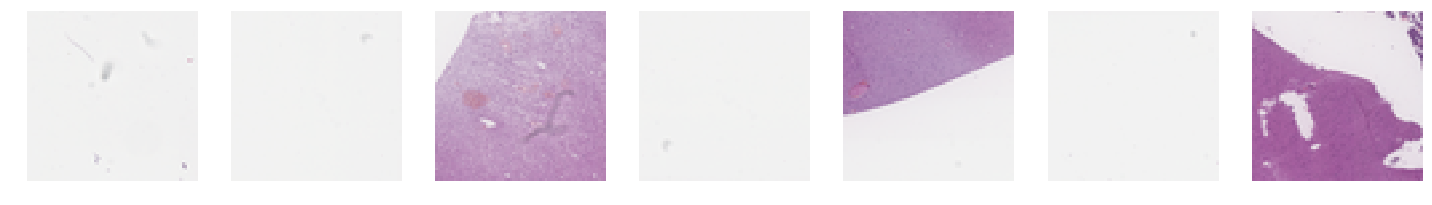

In [49]:
tk.show_images(dataset.train.images, 7, 1)

We can also view the labels associated with these patches.

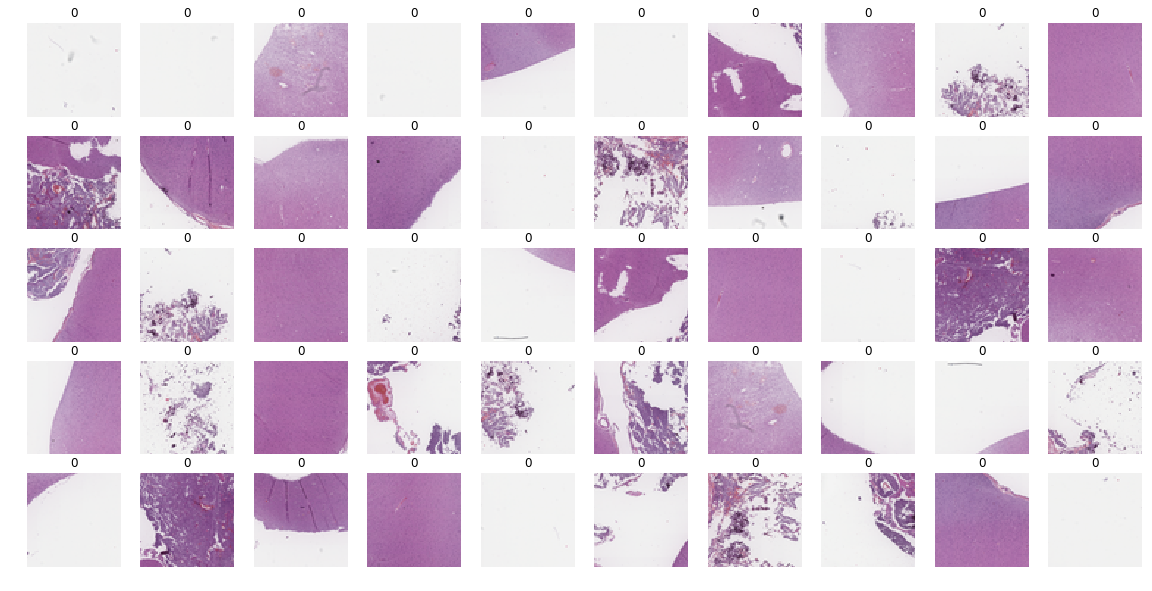

In [50]:
tk.show_labeled_patches(dataset.train.images, dataset.train.image_cls)